# King County Housing Data Project

## Outline
-[Library & Data Import](#Library-&-Data-Import) <br>
-[Function Creation](#Function-Creation) <br>
-[Data Investigation](#Data-Investigation) <br>
-[Data Scrub](#Data-Scrub) <br>
-[Data Exploration](#Data-Exploration) <br>
-[Further Examining Variable Features](#Further-Examining-Variable-Features) <br>
-[Model Creation & Experimentation](#Model-Creation-&-Experimentation) <br>
-[Validation](#Validation) <br>
-[Results & Summary](#Results-&-Summary)

## Library & Data Import

In [1]:
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('kc_house_data.csv')

## Function Creation

In [3]:
# Creating a Heatmap that can be easily altered to look at different correlations.
def make_heatmap(df = df, columns = None, figsize = (20, 20)):
    if columns is None:
        corr = df.corr()
    else:
        corr = df[columns].corr()
    plt.figure(figsize = figsize)
    sns.heatmap(np.abs(corr), cmap = sns.color_palette('Blues'), annot = True, fmt = '0.2g')
    plt.show()

In [4]:
# Creating an OLS Model that can be easily altered to look at the results.
def make_ols_model(df = df, target = 'price', columns_to_use = None, add_constant = True):
    X = df[columns_to_use]
    y = df[target]
    if add_constant:
        X = sm.add_constant(X)
    ols = sm.OLS(y, X)
    results = ols.fit()
    print(results.summary())
    return ols, results

In [5]:
# Creating Histograms to help view data normalization.
def make_histogram(df = df, column = 'price', bins = 20):
    plt.figure(figsize = (8, 5))
    plt.hist(df[column], bins = bins)
    plt.title(column)
    plt.show()

In [6]:
# Creating Linear Regression graphs that can look at single or multiple columns, and lay them out nicely if multiple.
def make_reg_graph(df = df, columns = None, target = 'price', figsize = (8,8)):
    y = df[target].values.reshape(-1, 1)
    linreg = LinearRegression()
    if type(columns) != str:
        snum = np.sqrt(len(columns))+1
        plt.figure(figsize = figsize)
        for i, col in enumerate(columns):
            ax = plt.subplot(snum, snum, i+1)
            X = df[col].values.reshape(-1, 1)
            linreg.fit(X, y)
            y_pred = linreg.predict(X)
            ax.scatter(X, y, color = 'blue')
            ax.plot(X, y_pred, color = 'red')
            plt.xlabel(col.title().replace('_', ' '))
            plt.ylabel('Price')
        plt.tight_layout()
    else:
        X = df[columns].values.reshape(-1, 1)
        linreg.fit(X, y)
        y_pred = linreg.predict(X)
        plt.scatter(X, y, color = 'blue')
        plt.plot(X, y_pred, color = 'red')
        plt.xlabel(columns.title().replace('_', ' '))
        plt.ylabel('Price')

In [7]:
# Plotting residuals to see outliers and homoskedacity.
def make_residual_plots(residuals):
    x = np.linspace(0, 1, residuals.shape[0])
    plt.figure(figsize=(8, 5))
    plt.scatter(x, residuals, alpha=0.7, c='purple')
    plt.title("Residuals")
    plt.hlines(y=0, colors='r', xmin=0, xmax=1, linewidth=3)
    plt.show()    
    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=20, color='purple')
    plt.title("Residuals Histogram")
    plt.show()

## Data Investigation

In [8]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [9]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [10]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [11]:
df.waterfront.value_counts()
df.view.value_counts()
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
1989.0       20
2006.0       20
2002.0       17
1991.0       16
1998.0       16
1984.0       16
1999.0       15
2008.0       15
2010.0       15
2001.0       15
1983.0       15
2015.0       14
1985.0       14
1986.0       14
1987.0       14
1994.0       14
1992.0       13
1993.0       12
1997.0       12
1995.0       12
          ...  
1975.0        5
1964.0        5
1969.0        4
1963.0        4
1973.0        4
1981.0        4
1965.0        4
1978.0        3
1960.0        3
1958.0        3
1956.0        3
1955.0        3
1945.0        3
1972.0        3
1967.0        2
1957.0        2
1940.0        2
1974.0        2
1962.0        2
1953.0        1
1950.0        1
1934.0        1
1944.0        1
1976.0        1
1948.0        1
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Leng

## Data Scrub

In [12]:
df = df.drop('id', axis = 1) # Removing unnecessary ID Column, no effect on Price.

In [13]:
# All NaN values are in columns that have a zero value where there either is no data or a categorical
# false value, so replacing all NaN values across the board with a zero value is valid.
df.fillna(value = 0, inplace = True)
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [14]:
#Investigating columns with type Object for null or dummy values
df.sqft_basement.value_counts()
df.loc[df['sqft_basement'] != '?', 'sqft_basement'].astype(float).mean()
df.loc[df['sqft_basement'] != '?', 'sqft_basement'].astype(float).median()
# Median Value is 0, as expected based on the value count. Assumption that ? value is an unknown, while
# 0 values are houses known to have no basement. Choosing to change ? to 0 values due to relatively low 
# number (454), and convert whole column to float to be easier to work with.
df['sqft_basement'].replace(to_replace = '?', value = 0, inplace = True)
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [15]:
# Converting Date column to datetime type.
df['date'] = pd.to_datetime(df['date'], format = '%m/%d/%Y')

In [16]:
# Binning Date column into seasons to look at sale prices per season.
df['season'] = (df['date'].dt.month)//3
df['season'].replace(to_replace = 4, value = 0, inplace = True)
df['season'].value_counts()

1    6518
2    6328
3    5056
0    3695
Name: season, dtype: int64

## Data Exploration

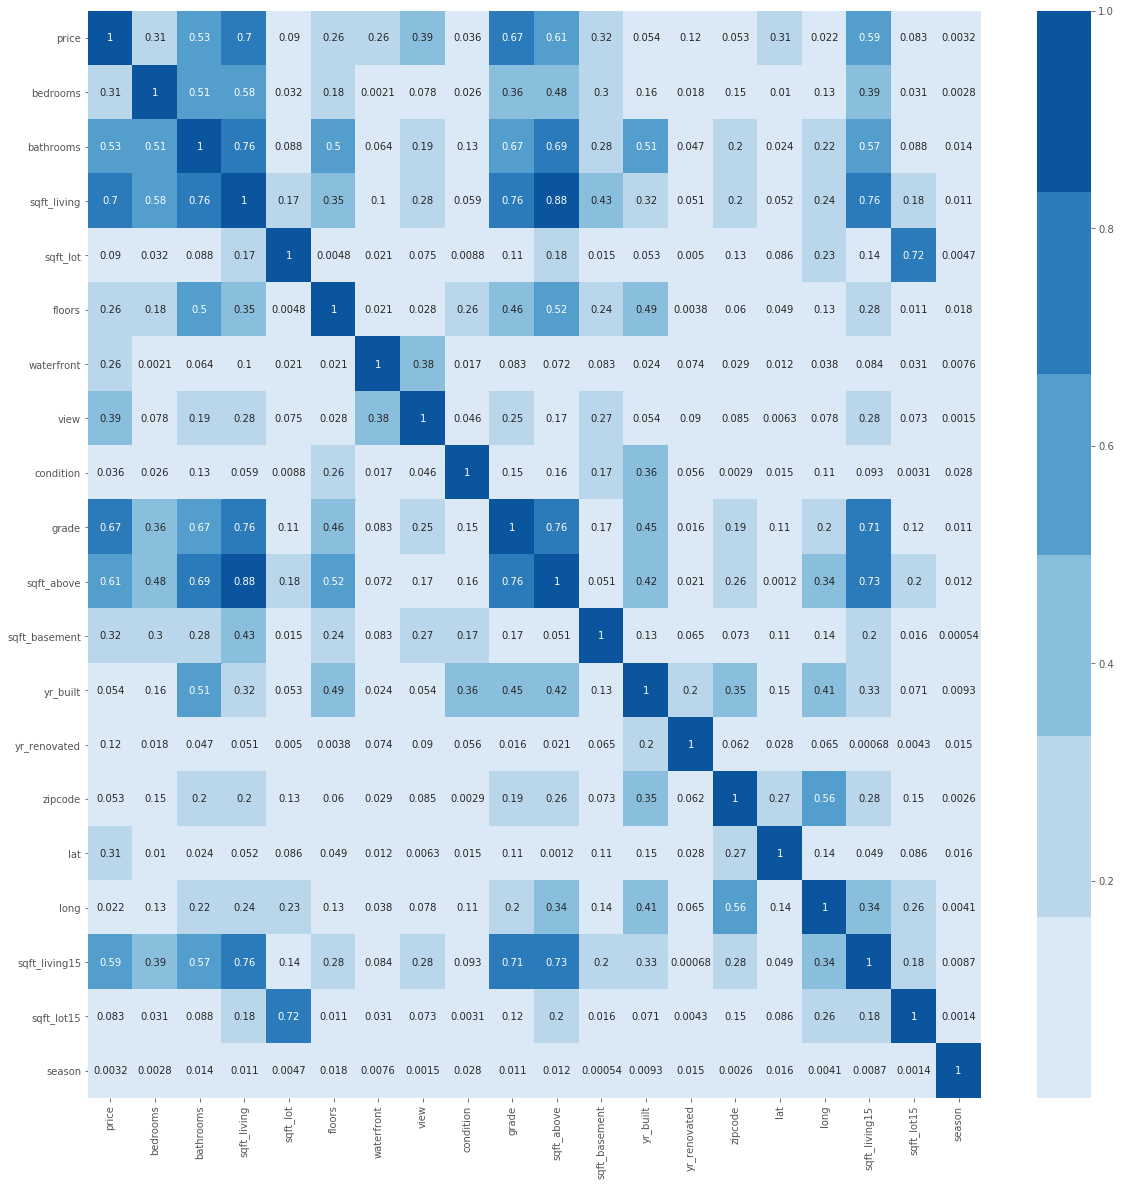

In [17]:
make_heatmap(df = df, columns = df.columns)

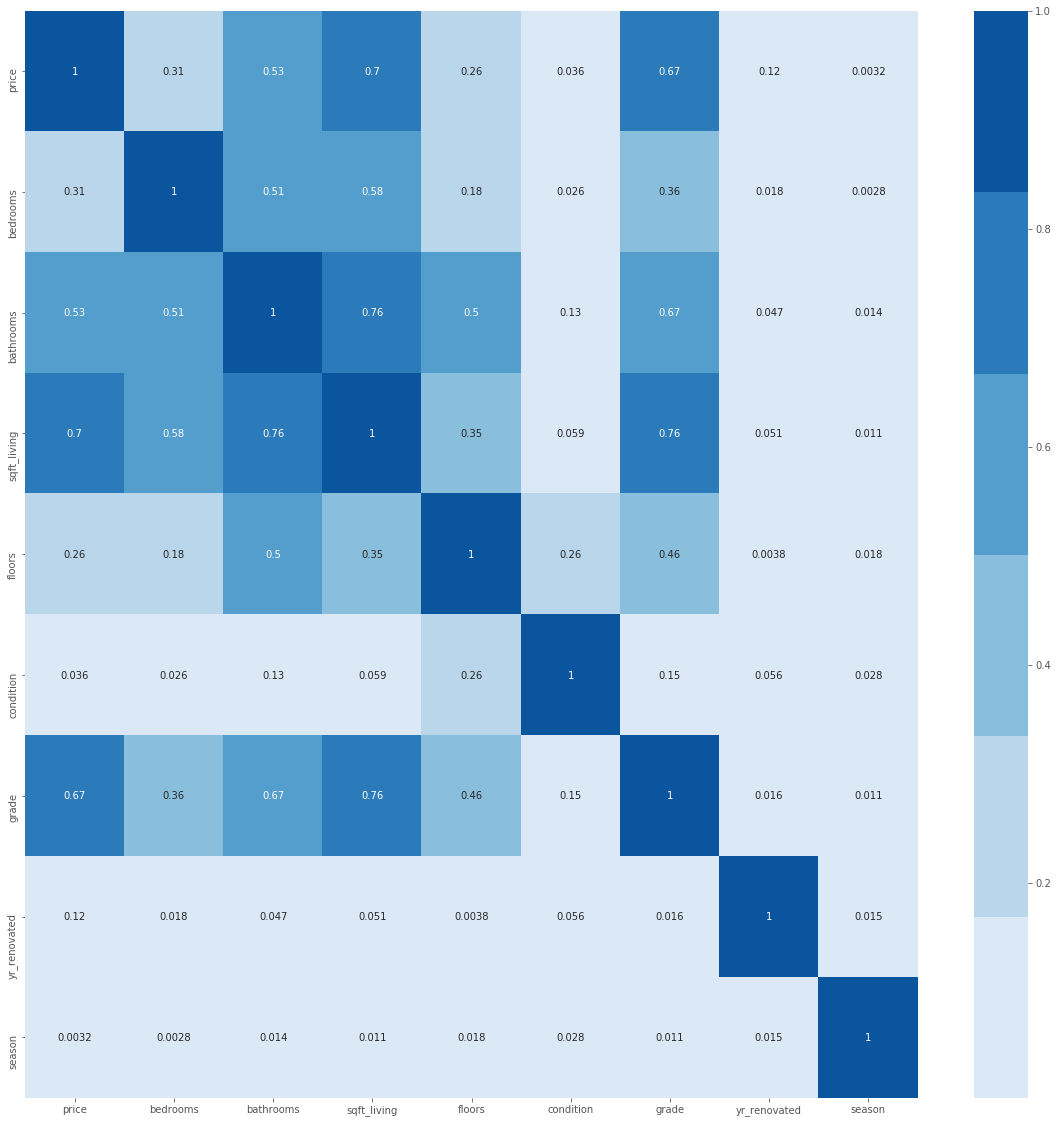

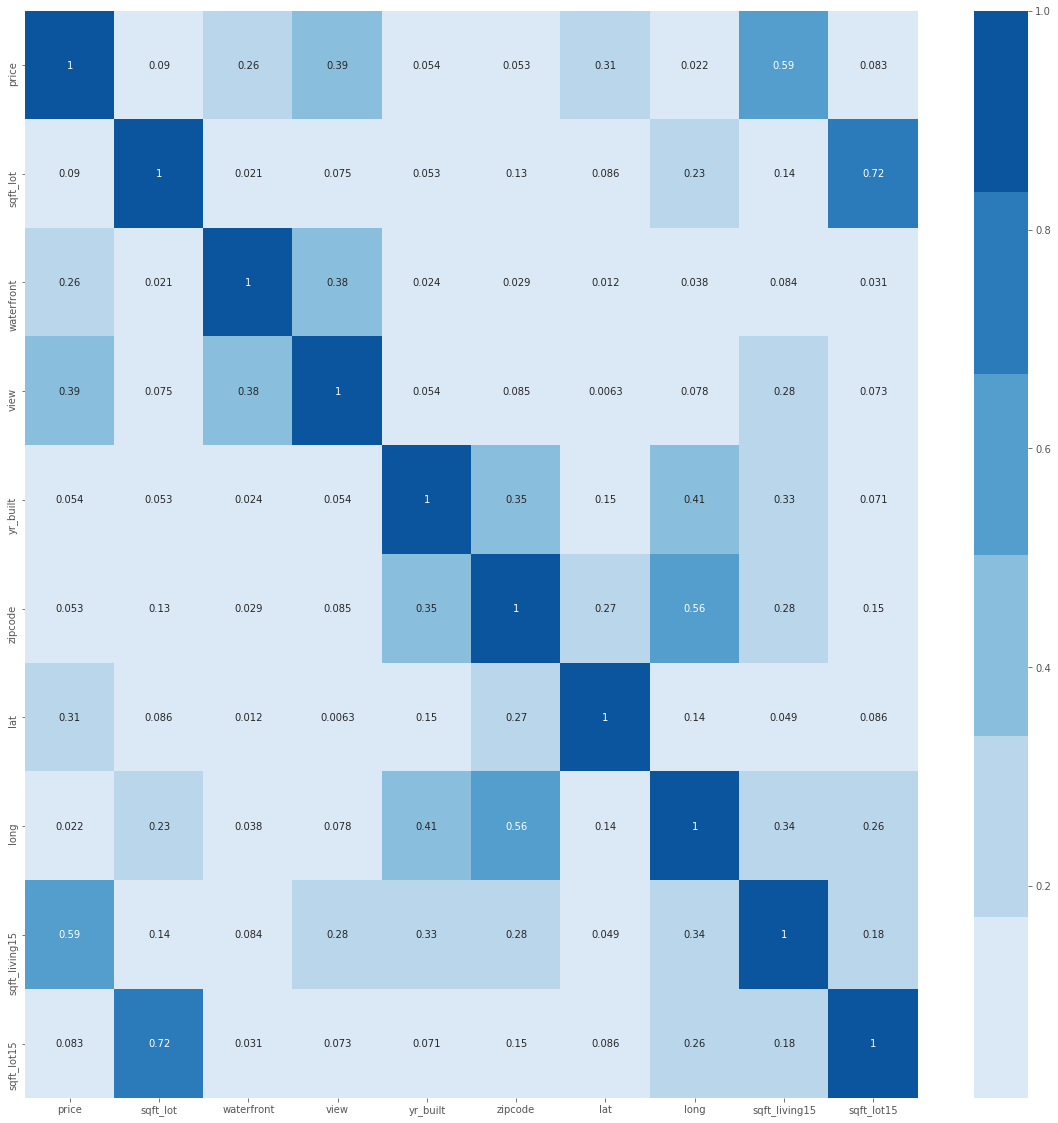

In [18]:
# Dividing columns into what can be somewhat easily changed during a renovation vs what is
# static about the house. Price is included in both lists as the target value for comparison.
# Sqft_above and sqft_basement are left out due to being included in sqft_living.
variable_features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 
                     'condition', 'grade', 'yr_renovated', 'season']
non_variable_features = ['price', 'sqft_lot', 'waterfront', 'view', 'yr_built', 
                         'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

make_heatmap(df = df, columns = variable_features)
make_heatmap(df = df, columns = non_variable_features)

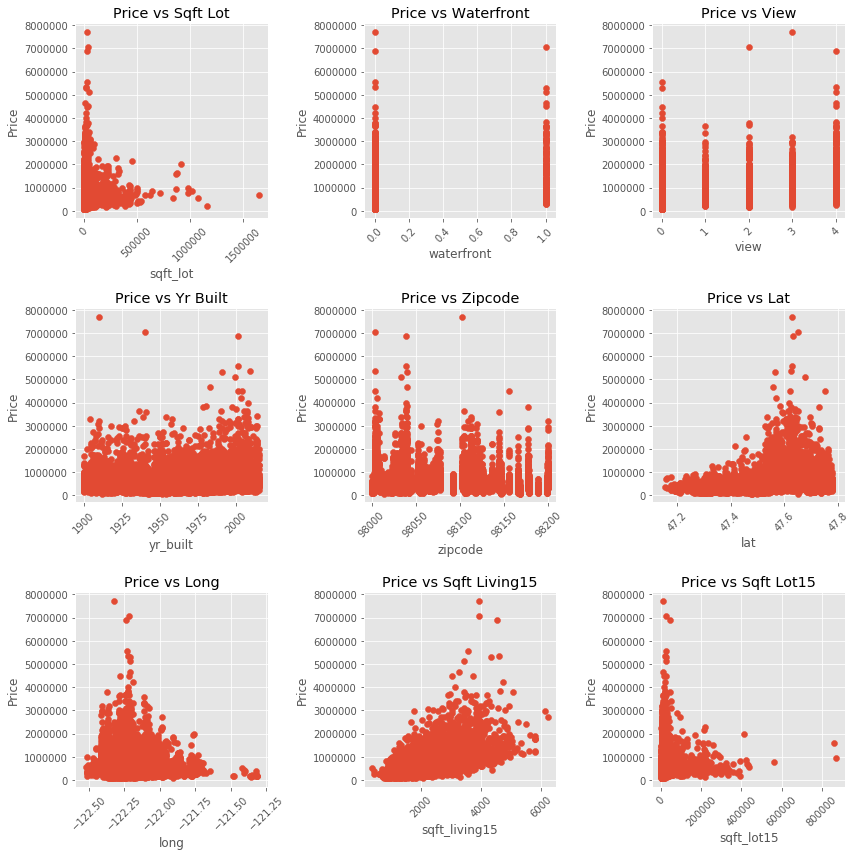

In [19]:
# Creating visuals of each non-variable feature vs price to eventually compare to the variable features.
non_variable_features = ['sqft_lot', 'waterfront', 'view', 'yr_built', 
                         'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
fig = plt.figure(figsize = (12,12))
for i, col in enumerate(non_variable_features):
    ax = fig.add_subplot(3, 3, i+1)
    plt.scatter(df[col], df['price'])
    plt.ylabel('Price')
    plt.xlabel(col)
    plt.xticks(rotation = 45)
    plt.title('Price vs {}'.format(col.title().replace('_', ' ')))
    plt.tight_layout()

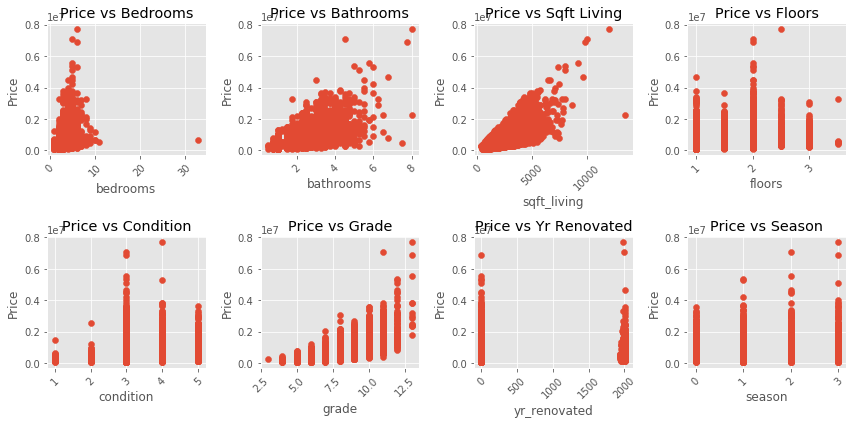

In [20]:
# Creating visuals of each variable feature vs price to compare to the non-variable features.
variable_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 
                     'condition', 'grade', 'yr_renovated', 'season']
fig = plt.figure(figsize = (12,6))
for i, col in enumerate(variable_features):
    ax = fig.add_subplot(2, 4, i+1)
    plt.scatter(df[col], df['price'])
    plt.ylabel('Price')
    plt.xlabel(col)
    plt.xticks(rotation = 45)
    plt.title('Price vs {}'.format(col.title().replace('_', ' ')))
    plt.tight_layout()

## Further Examining Variable Features

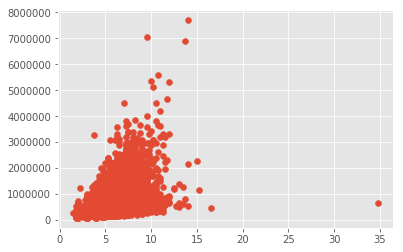

In [21]:
df['total_rooms'] = df['bathrooms'] + df['bedrooms']
plt.scatter(df['total_rooms'], df['price'])

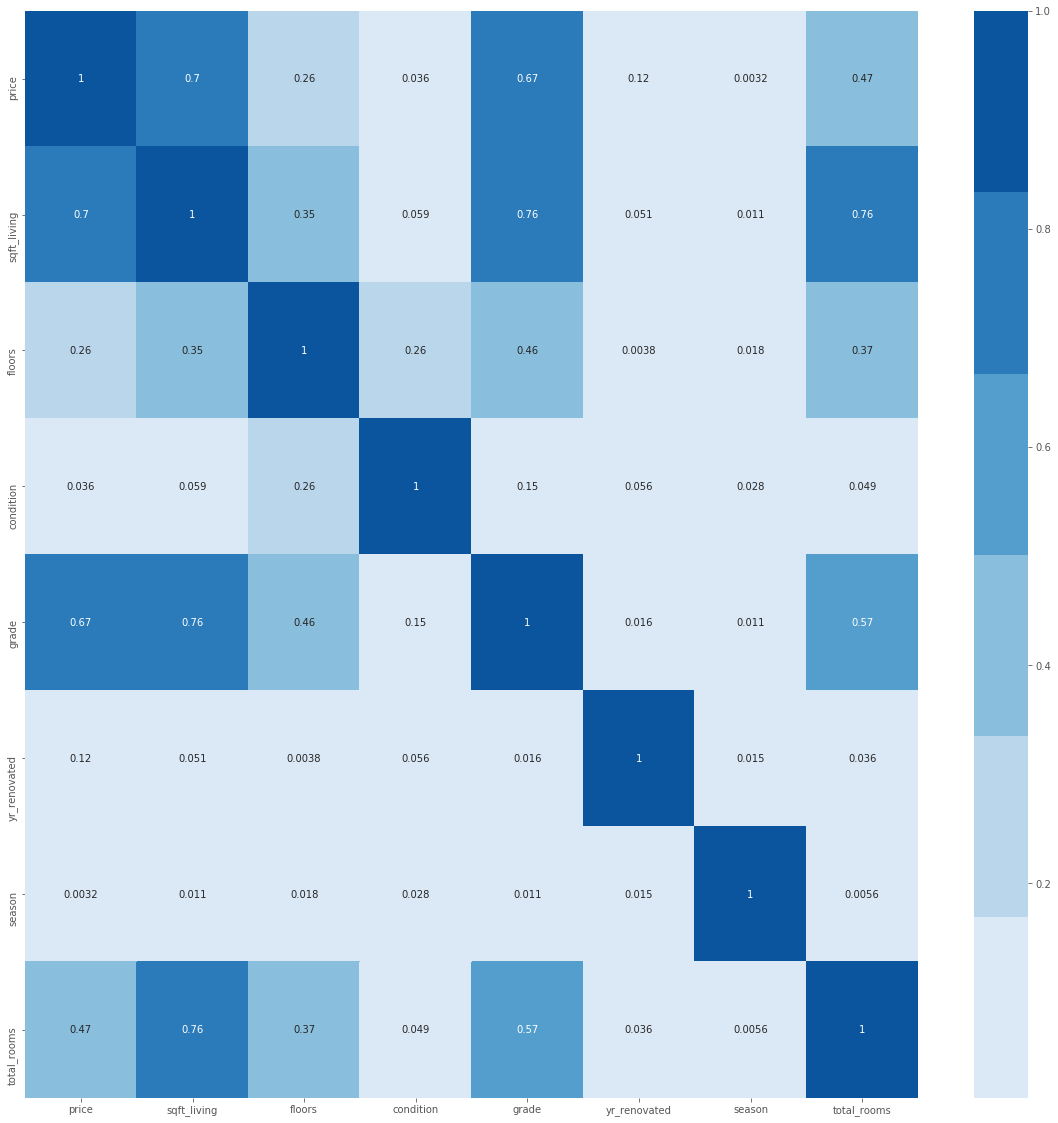

In [22]:
variable_features = ['price', 'sqft_living', 'floors', 'condition', 
                     'grade', 'yr_renovated', 'season', 'total_rooms']
make_heatmap(df = df, columns = variable_features)

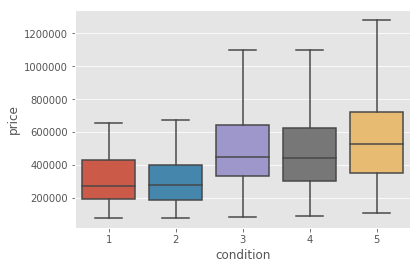

In [23]:
# Average Price at each Condition tier excluding outliers.
sns.boxplot(df['condition'], df['price'], showfliers = False)

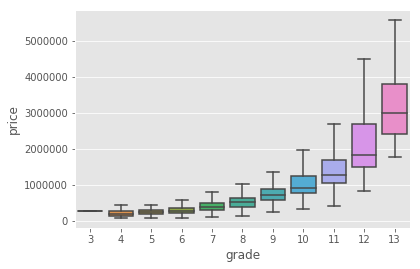

In [24]:
# Average Price at each Grade tier excluding outliers.
sns.boxplot(df['grade'], df['price'], showfliers = False)

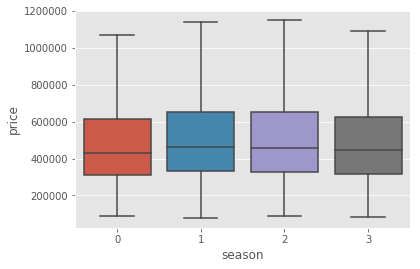

In [25]:
# Average Price for each Season excluding outliers.
sns.boxplot(df['season'], df['price'], showfliers = False)

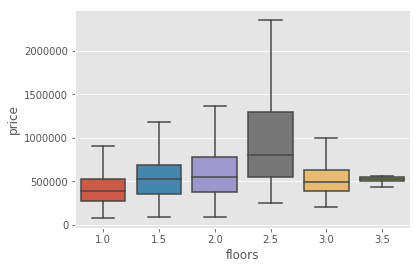

In [26]:
# Average Price for each Floor amount excluding outliers.
sns.boxplot(df['floors'], df['price'], showfliers = False)

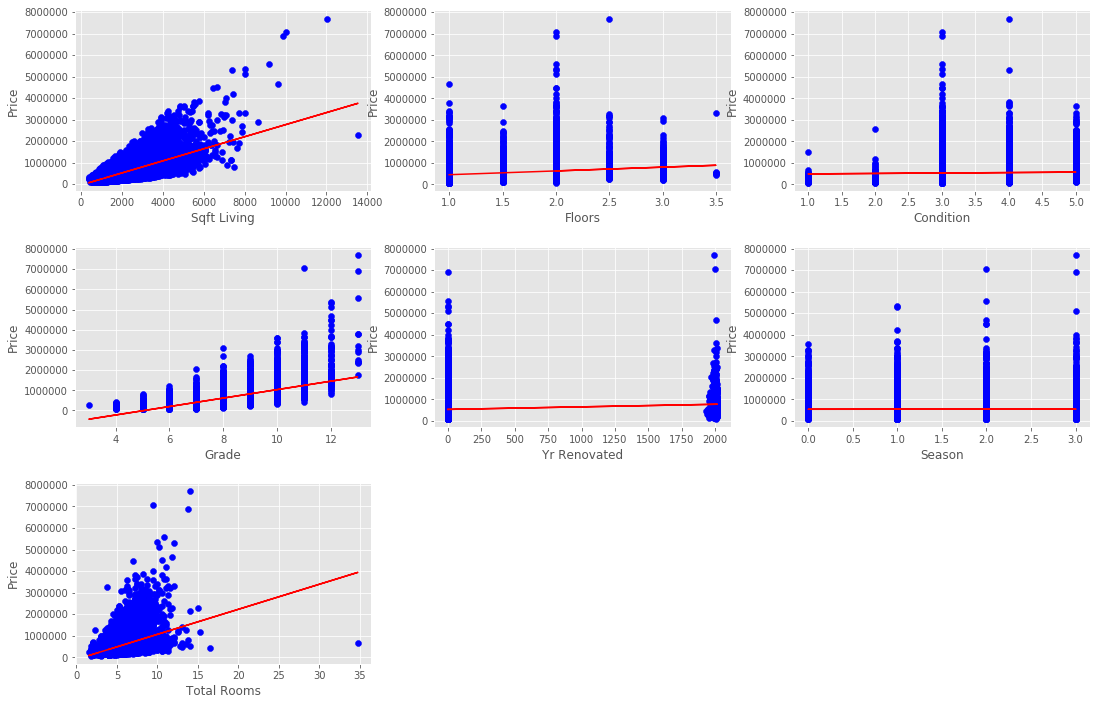

In [27]:
variable_features = ['sqft_living', 'floors', 'condition', 
                     'grade', 'yr_renovated', 'season', 'total_rooms']
make_reg_graph(df, columns = variable_features, figsize = (15, 10))

## Model Creation & Experimentation

In [28]:
# Experiment #1
variable_features = ['sqft_living', 'floors', 'condition', 
                     'grade', 'yr_renovated', 'season', 'total_rooms']
ols, res = make_ols_model(df, columns_to_use = variable_features, add_constant = False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                 1.754e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:34:51   Log-Likelihood:            -2.9931e+05
No. Observations:               21597   AIC:                         5.986e+05
Df Residuals:                   21590   BIC:                         5.987e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
sqft_living    296.5592      3.130     94.740   

### Experiment #1 Observations
With Constant: Decent R-Squared, very high Condition Number. <br>
Without Constant: Very good R-Squared, lower but still quite high Condition Number. <br>
Next Step: Remove Total Rooms to check for Multicolinearity with Sqft Living.

In [29]:
# Experiment #2
variable_features = ['sqft_living', 'floors', 'condition', 
                     'grade', 'yr_renovated', 'season']
ols, res = make_ols_model(df, columns_to_use = variable_features, add_constant = False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 1.939e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:35:00   Log-Likelihood:            -2.9980e+05
No. Observations:               21597   AIC:                         5.996e+05
Df Residuals:                   21591   BIC:                         5.997e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
sqft_living    240.7123      2.648     90.916   

### Experiment #2 Observations
Very similar results, Condition has come down slightly, but so has R-Squared. <br>
Next Step: Try normalizing Sqft Living to see if that has an effect with and without Total Rooms.

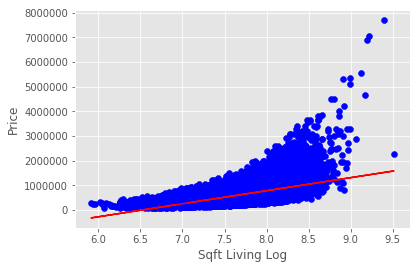

In [30]:
df['sqft_living_log'] = np.log(df['sqft_living'])
make_reg_graph(df, columns = 'sqft_living_log')

In [31]:
# Experiment #3
variable_features = ['sqft_living_log', 'floors', 'condition', 
                     'grade', 'yr_renovated', 'season', 'total_rooms']
ols, res = make_ols_model(df, columns_to_use = variable_features, add_constant = False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                 1.437e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:35:03   Log-Likelihood:            -3.0111e+05
No. Observations:               21597   AIC:                         6.022e+05
Df Residuals:                   21590   BIC:                         6.023e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqft_living_log -1.979e+05   3024.500    -

### Experiment #3 Observations
Log Normalizing Sqft Living has resulted in much better Condition Number, and now adding Total Rooms back increases the R-Squared without affecting the Condition Number. Kurtosis is also better with Total Rooms than without, however, was highly affected by the normalization. <br>
Next Step: Check Histograms of features to look for Skew and Kurtosis, and find ones that may need to be removed.

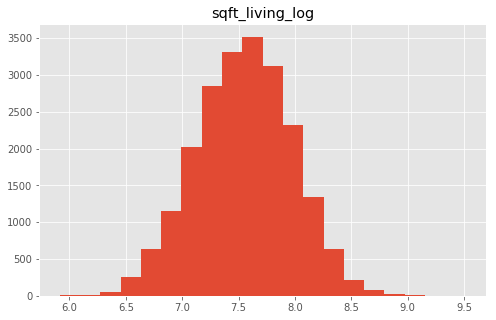

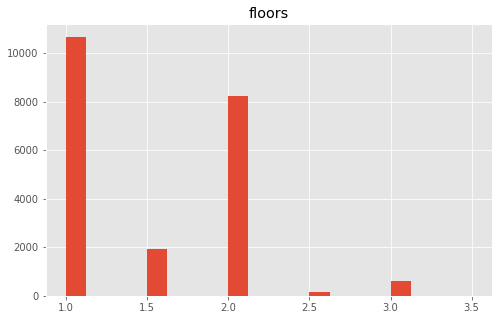

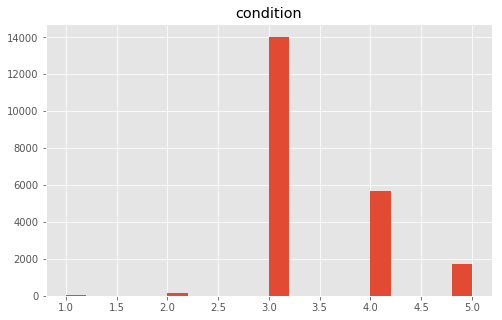

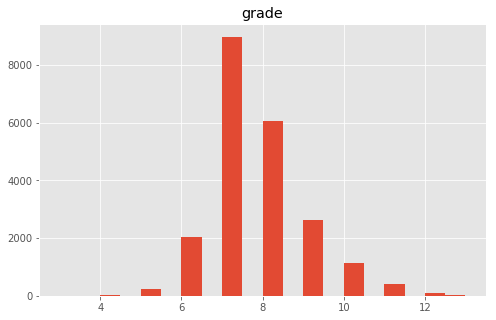

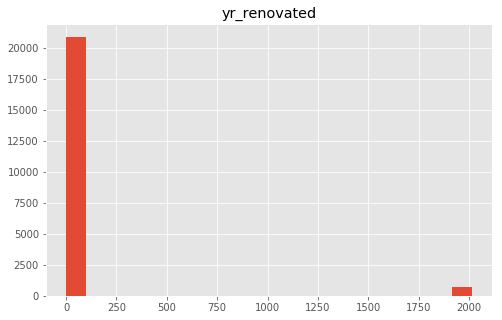

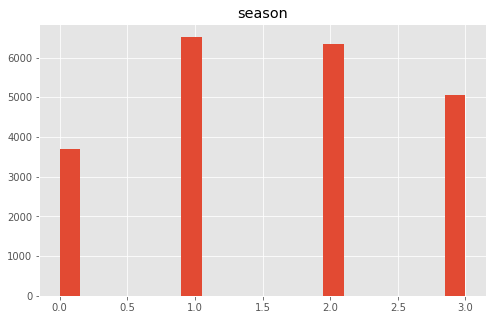

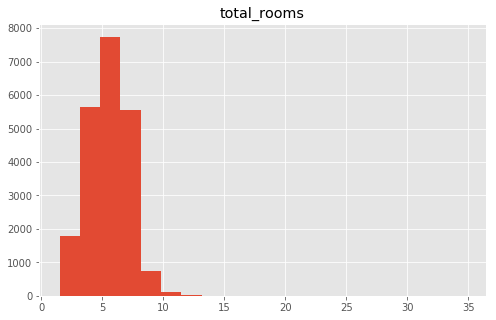

In [32]:
for col in variable_features:
    make_histogram(df, col)

In [33]:
# Removing single item that had more than 30 rooms.
df = df.loc[df['total_rooms'] < 30]

In [34]:
# Experiment #4
variable_features = ['sqft_living_log', 'floors', 'condition', 
                     'grade', 'season', 'total_rooms']
ols, res = make_ols_model(df, columns_to_use = variable_features, add_constant = False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                 1.636e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:35:10   Log-Likelihood:            -3.0131e+05
No. Observations:               21596   AIC:                         6.026e+05
Df Residuals:                   21590   BIC:                         6.027e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqft_living_log -1.949e+05   3053.598    -

In [35]:
residuals = res.resid

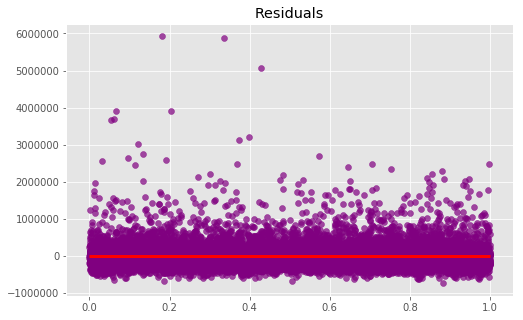

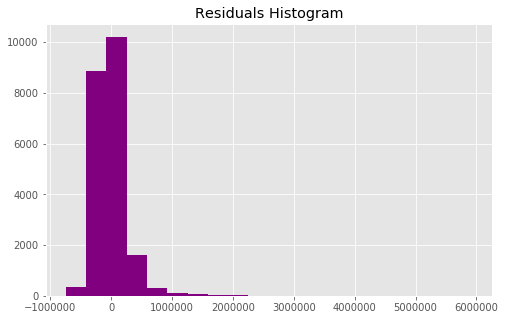

In [36]:
make_residual_plots(residuals = residuals)

### Experiment #4 Observations
Condition Number continues to improve, skew and kurtosis do not. <br>
Next Step: Remove outlier residuals to improve overall performance of model.

In [37]:
indices_to_drop = np.where(residuals > 1000000)[0]

In [38]:
indices_to_drop

array([   21,   246,   269,   282,   300,   312,   518,   656,   779,
         814,  1030,  1150,  1162,  1215,  1270,  1280,  1313,  1359,
        1431,  1446,  1674,  1768,  1943,  2038,  2083,  2138,  2265,
        2318,  2442,  2471,  2624,  2862,  2897,  2972,  3018,  3037,
        3089,  3278,  3381,  3515,  3731,  3744,  3809,  3857,  3867,
        3910,  4009,  4028,  4031,  4145,  4186,  4264,  4335,  4407,
        4631,  4758,  4855,  4917,  4918,  5444,  5584,  5612,  5697,
        5874,  5961,  6039,  6189,  6329,  6396,  6502,  6708,  6765,
        6777,  7028,  7184,  7245,  7304,  7306,  7425,  7499,  7645,
        7693,  7900,  7904,  7926,  7982,  8042,  8085,  8184,  8215,
        8629,  9166,  9245,  9313,  9478,  9599, 10252, 10362, 10435,
       10454, 11213, 11245, 11266, 11434, 11453, 11523, 11608, 11674,
       11940, 11963, 12174, 12358, 12447, 12601, 12636, 12638, 12700,
       12813, 12859, 13007, 13058, 13243, 13406, 13515, 13662, 13697,
       13774, 13954,

In [39]:
df_trimmed = df.drop(index = indices_to_drop)
df_trimmed.iloc[20:25]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,season,total_rooms,sqft_living_log
20,2014-05-14,385000.0,4,1.75,1620,4980,1.0,0.0,0.0,4,...,1947,0.0,98133,47.7025,-122.341,1400,4980,1,5.75,7.390181
22,2014-07-03,285000.0,5,2.50,2270,6300,2.0,0.0,0.0,3,...,1995,0.0,98092,47.3266,-122.169,2240,7005,2,7.50,7.727535
23,2014-05-16,252700.0,2,1.50,1070,9643,1.0,0.0,0.0,3,...,1985,0.0,98030,47.3533,-122.166,1220,8386,1,3.50,6.975414
24,2014-11-20,329000.0,3,2.25,2450,6500,2.0,0.0,0.0,4,...,1985,0.0,98030,47.3739,-122.172,2200,6865,3,5.25,7.803843
25,2014-11-03,233000.0,3,2.00,1710,4697,1.5,0.0,0.0,5,...,1941,0.0,98002,47.3048,-122.218,1030,4705,3,5.00,7.444249


In [40]:
df_trimmed.reset_index(drop = True, inplace = True)
df_trimmed.iloc[20:25]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,season,total_rooms,sqft_living_log
20,2014-05-14,385000.0,4,1.75,1620,4980,1.0,0.0,0.0,4,...,1947,0.0,98133,47.7025,-122.341,1400,4980,1,5.75,7.390181
21,2014-07-03,285000.0,5,2.50,2270,6300,2.0,0.0,0.0,3,...,1995,0.0,98092,47.3266,-122.169,2240,7005,2,7.50,7.727535
22,2014-05-16,252700.0,2,1.50,1070,9643,1.0,0.0,0.0,3,...,1985,0.0,98030,47.3533,-122.166,1220,8386,1,3.50,6.975414
23,2014-11-20,329000.0,3,2.25,2450,6500,2.0,0.0,0.0,4,...,1985,0.0,98030,47.3739,-122.172,2200,6865,3,5.25,7.803843
24,2014-11-03,233000.0,3,2.00,1710,4697,1.5,0.0,0.0,5,...,1941,0.0,98002,47.3048,-122.218,1030,4705,3,5.00,7.444249


In [41]:
# Experiment #5
variable_features = ['sqft_living_log', 'floors', 'condition', 
                     'grade', 'season', 'total_rooms']
ols, res = make_ols_model(df = df_trimmed, columns_to_use = variable_features, add_constant = False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 2.182e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:35:31   Log-Likelihood:            -2.9415e+05
No. Observations:               21383   AIC:                         5.883e+05
Df Residuals:                   21377   BIC:                         5.884e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqft_living_log -1.619e+05   2548.871    -

### Experiment #5 Observations
R-Squared improved a bit, Condition Number didn't change, Skew and Kurtosis fell dramatically. Attempting one more run of residual outlier removal.

In [42]:
residuals = res.resid

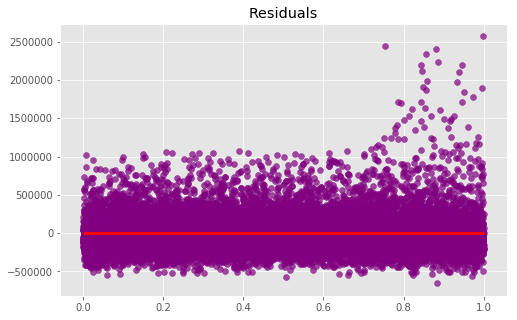

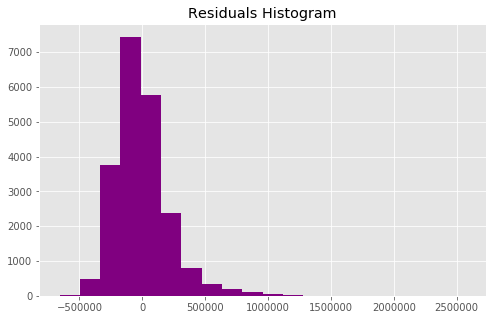

In [43]:
make_residual_plots(residuals = residuals)

In [44]:
indices_to_drop2 = np.where(residuals > 1000000)[0]
indices_to_drop2

array([  152,  3189,  4428,  4751,  5795,  6160,  6922,  8346,  8810,
       10357, 11287, 11650, 13132, 14086, 14979, 15001, 15387, 15512,
       15661, 15723, 15954, 16082, 16087, 16130, 16441, 16643, 16650,
       16768, 16792, 16823, 16972, 17108, 17147, 17376, 17584, 17715,
       18014, 18020, 18021, 18038, 18113, 18138, 18217, 18262, 18283,
       18287, 18360, 18571, 18595, 18677, 18682, 18711, 18815, 18945,
       19032, 19119, 19147, 19278, 19323, 19477, 19551, 19569, 19614,
       19648, 19773, 19798, 19931, 19940, 20032, 20079, 20108, 20151,
       20222, 20240, 20314, 20442, 20544, 20816, 20916, 20975, 21083,
       21140, 21301, 21346], dtype=int64)

In [45]:
df_trimmed2 = df_trimmed.drop(index = indices_to_drop2)

In [46]:
df_trimmed2.iloc[149:153]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,season,total_rooms,sqft_living_log
149,2014-08-20,532170.0,3,2.0,1360,3090,2.0,0.0,0.0,3,...,1990,0.0,98103,47.6838,-122.353,1500,3090,2,5.0,7.215240
150,2015-04-09,560000.0,3,1.0,1110,5000,1.5,0.0,0.0,3,...,1947,0.0,98107,47.6550,-122.359,1420,5000,1,4.0,7.012115
151,2015-03-31,282950.0,3,1.0,1250,8200,1.0,0.0,0.0,4,...,1954,0.0,98003,47.3255,-122.304,1680,8633,1,4.0,7.130899
153,2014-05-16,350000.0,1,1.0,700,5100,1.0,0.0,0.0,3,...,1942,0.0,98115,47.6790,-122.300,1010,5100,1,2.0,6.551080


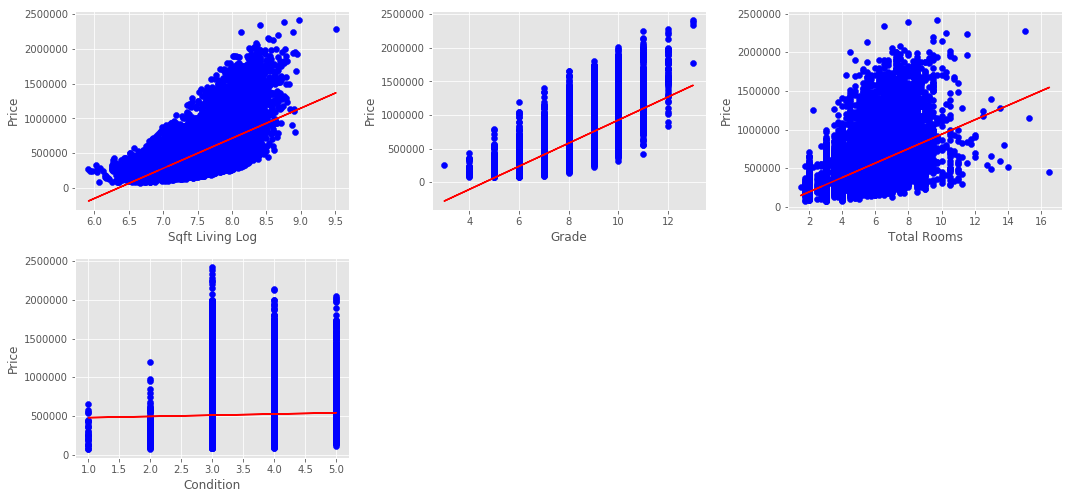

In [49]:
variable_features = ['sqft_living_log', 'grade', 
                    'total_rooms', 'condition']
make_reg_graph(df = df_trimmed2, columns = variable_features, figsize = (15, 10))

In [50]:
# Removing outliers from sqft_living and grade
df_trimmed2 = df_trimmed2.loc[df_trimmed2['sqft_living_log'] < 9.3]
df_trimmed2 = df_trimmed2.loc[df_trimmed2['grade'] >= 4]
df_trimmed2 = df_trimmed2.loc[df_trimmed2['grade'] <= 12]

In [51]:
# Experiment #6
variable_features = ['sqft_living_log', 'condition', 
                     'grade', 'total_rooms']
ols, res = make_ols_model(df = df_trimmed2, columns_to_use = variable_features, add_constant = False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 3.702e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:36:40   Log-Likelihood:            -2.9103e+05
No. Observations:               21293   AIC:                         5.821e+05
Df Residuals:                   21289   BIC:                         5.821e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqft_living_log -1.484e+05   2324.650    -

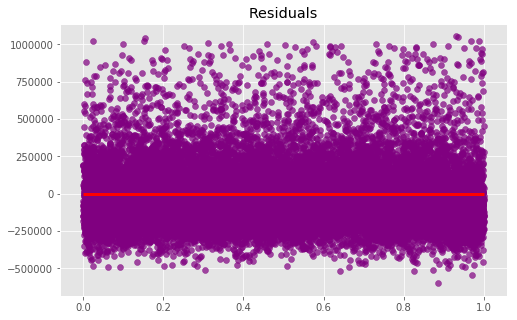

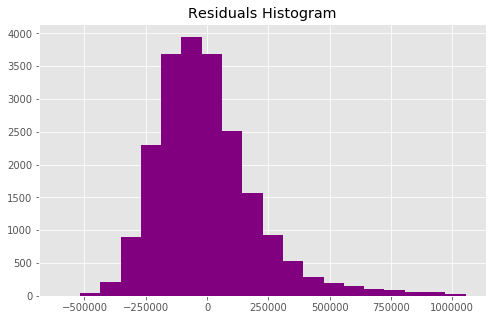

In [52]:
residuals = res.resid
make_residual_plots(residuals = residuals)

### Experiment #6 Observations
R-Squared, P-Values, Condition Number, Skew, and Kurtosis are all looking pretty great. Moving on to validation.

## Validation

In [53]:
variable_features = ['sqft_living_log', 'grade', 
                     'total_rooms', 'condition']
X = df_trimmed2[variable_features]
y = df_trimmed2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

linreg = LinearRegression(fit_intercept = False)

linreg.fit(X_train, y_train)

print(linreg.score(X_test, y_test))
print(linreg.score(X_train, y_train))
print(linreg.score(X, y))

print(linreg.coef_)

0.46726117492541175
0.44791299575109983
0.45297288211429293
[-146177.94552146  162290.85186522   47053.30400782   36861.60761345]


In [54]:
cv = cross_val_score(linreg, X, y, cv=5, n_jobs=-1, scoring='r2', verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


In [55]:
cv

array([0.45143528, 0.43506335, 0.45128987, 0.468521  , 0.44866114])

In [56]:
cv.mean()

0.45099412933388283

In [57]:
cv.std()

0.010646181347353895

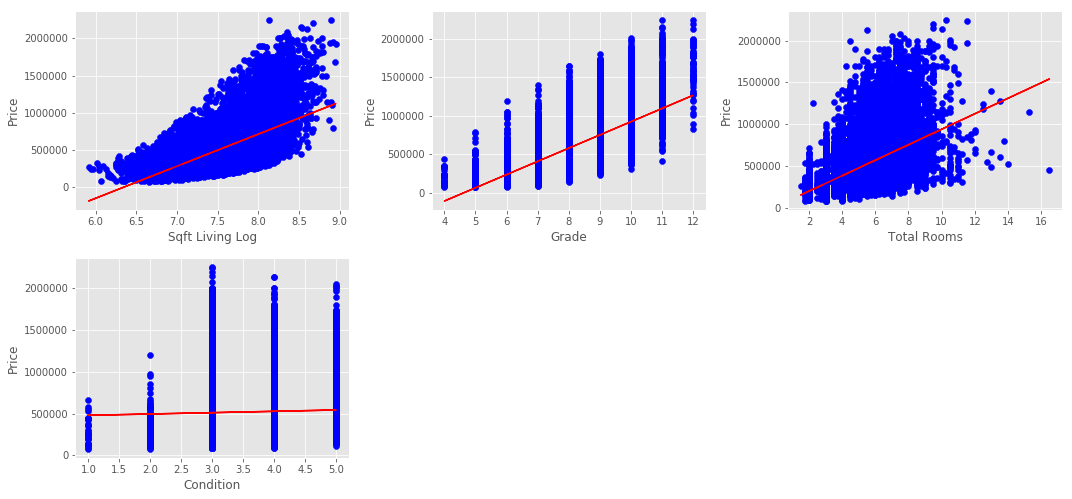

In [58]:
variable_features = ['sqft_living_log', 'grade', 
                    'total_rooms', 'condition']
make_reg_graph(df = df_trimmed2, columns = variable_features, figsize = (15, 10))

## Results & Summary

### Result Numbers
My final model ended with an R-Squared of 0.874, indicating that our best fit lines match the data very well for the most part. All P-Values are 0, along with the Probability of F-Statistic, which signals pretty high confidence that our chosen features are not random, and can linearly predict our target. Our Condition Number is pretty low, which in itself doesn't mean there's no multicolinearity, but would be an indicator of it were it higher. Our Skew and Kurtosis, while certainly not perfect, are fairly low which suggests some decent normality throughout our chosen features. Lastly, our Residuals are spread very evenly over their plot, which suggests good homoskedasticity. That means that our errors are consistent across variables, and do not depend on the X Values.

### Summary & Recommendations
I feel pretty comfortable with this particular model based on the numbers presented above, and in a situation where I'm recommending certain features to a Home Renovation Company to suggest to their customers, I would recommend increasing the house's square footage, total number of rooms (be they bathrooms or bedrooms), the home's grade, which would include improving the building materials and building quality, and the overall condition of the home, in terms of cleanliness and any potential spot-repairs that need to be done.

### Next Steps & Future Work
Were I to continue investigating the data, I would push towards verifying that the chosen features are not multicolinear which, as it stands they seem to not be based on the Condition Number, but as there are signs of multicolinearity based on the correlation values in the heatmaps.

In the future, I would want to gather more data on other features that could be changed via renovation, such as adding a pool or upgrading the bathroom and kitchen fixtures, to see what effect that could have on the overall price.